In [2]:
# Set new current working directory path
import os
from pathlib import Path

os.chdir(Path.cwd().parent)
print('CWD After: ', Path.cwd())

CWD After:  /home/rivlanm/projects/nist_ppfl/NIST_PPFL_problem1_202503


In [3]:
import numpy as np
import pandas as pd
import pickle as pkl
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary

import matplotlib.pyplot as plt

# ART membership inference helper methods 
from art.attacks.inference.membership_inference import MembershipInferenceBlackBox
from art.estimators.classification import PyTorchClassifier

# pre trained models 
from problem1.attack_targets.cnn.model import Net as cnn_Net
from problem1.attack_targets.dpcnn10.model import Net as dpcnn10_Net
from problem1.attack_targets.dpcnn200.model import Net as dpcnn200_Net

# helper methods
from utils import load_model, load_data, load_path_set, build_attack_model, eval_model


/tmp/ipykernel_8576/1966918957.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## NIST Genomics PPFL Red Team Exercise
### Introductory tutorial for performing Membership Inference Attack on CNN trained on Soybean Genomics data

In [4]:
CLIENT_ID_SET = ['1', '2', '3', '4']
challenge_pred_set = []

In [5]:
MODEL_TYPE = 'dpcnn'  # or 'cnn'
PRIVACY_TYPE = 'dpcnn200'  # 'cnn' (no privacy), 'dpcnn10' (epsilon 10), dpcnn200 (epsilon 200)

In [6]:
# Path to challenge records data file for the client model
model_dir = Path(f'problem1/attack_targets/{PRIVACY_TYPE}')
challenge_data_path = Path(model_dir, f'{PRIVACY_TYPE}_challenge_records.dat')

# Challenge records are those for which the competitor need to classify. 
#   Each challenge record can be classified into 5 categories.
#   If a challenge record belongs to the client model, the competitor should classify it as the client number (1, 2, 3, or 4). 
#   Otherwise, the competitor should classify it as 0 --> which means the record does not belong to any client model in the selected privacy level / privacy type.
challenge_x, challenge_y = load_data(challenge_data_path)
print("shape, challenge records: {}".format(challenge_x.shape))


shape, challenge records: (73, 125766)


In [7]:
for client_id in CLIENT_ID_SET:
    print("Process attack model for client {}".format(int(client_id)))
    # load data and pre-trained model paths
    model_path, relevant_data_path, external_data_path, hyperparameters_path = load_path_set(privacy_type=PRIVACY_TYPE, 
                                                                                                                  client_id=client_id, 
                                                                                                                  model_type=MODEL_TYPE)
    
    # Relevant records are those which an attacker might believe belongs to the client model. 
    rel_x, rel_y = load_data(relevant_data_path)
    print("shape, relevant records: {}".format(rel_x.shape))

    # External records are those which an attacker believes do not belong to the client model. See problem statement for details.
    ext_x, ext_y = load_data(external_data_path)
    print("shape, external records: {}".format(ext_x.shape))
    print("==========\n")

    # load architecture for pre-trained clients (target of MI attack)
    if PRIVACY_TYPE == "cnn":
        model_class = cnn_Net
    elif PRIVACY_TYPE == "dpcnn10":
        model_class = dpcnn10_Net
    elif PRIVACY_TYPE == "dpcnn200":
        model_class = dpcnn200_Net
    else:
        raise ValueError("invalid model type")

    task_model = load_model(model_path=model_path, 
                            num_data_features=rel_x.shape[1], 
                            model_class=model_class)

    # build attack model
    attack_model = build_attack_model(task_model=task_model,
                                      num_data_features=rel_x.shape[1], 
                                      hyperparameters_path=hyperparameters_path)
    

    # Get client model's predictions on relevant and external data
    rel_x_preds = task_model(rel_x).squeeze()
    ext_x_preds = task_model(ext_x).squeeze()
    rel_x_preds = rel_x_preds.detach().numpy()
    ext_x_preds = ext_x_preds.detach().numpy()
    
    # challenge data predictions
    challenge_pred = eval_model(rel_x_preds, ext_x_preds, rel_y, ext_y, attack_model, rel_x, ext_x, challenge_x, challenge_y)
    # assign 
    challenge_pred_set.append(challenge_pred)

Process attack model for client 1
shape, relevant records: (73, 125766)
shape, external records: (64, 125766)

Process attack model for client 2
shape, relevant records: (95, 125766)
shape, external records: (83, 125766)

Process attack model for client 3
shape, relevant records: (59, 125766)
shape, external records: (52, 125766)

Process attack model for client 4
shape, relevant records: (23, 125766)
shape, external records: (20, 125766)



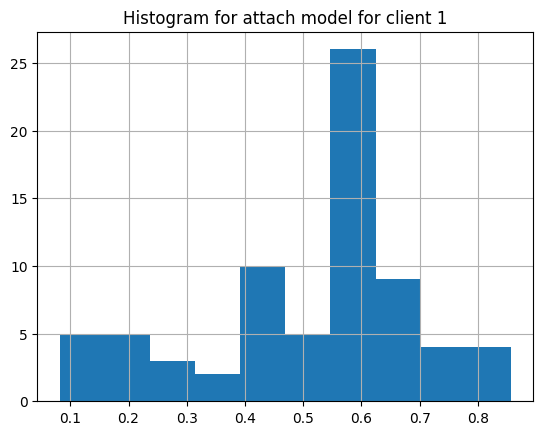

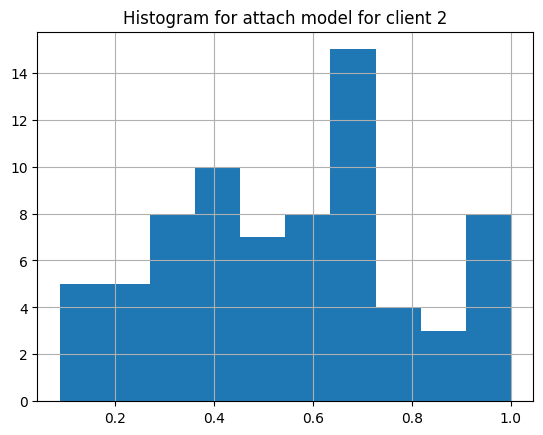

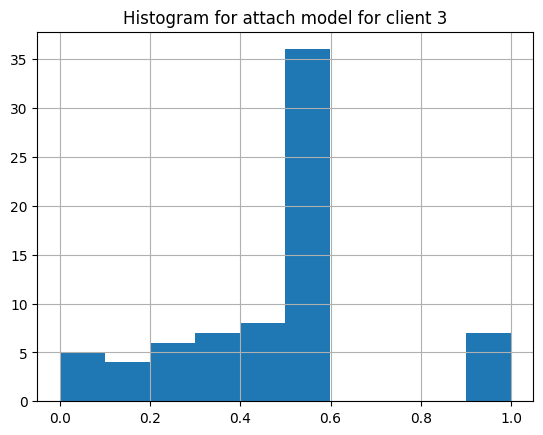

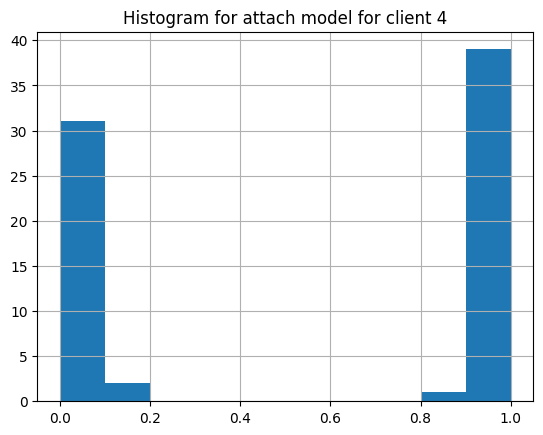

In [8]:
import matplotlib.pyplot as plt

for i, val in enumerate(challenge_pred_set):
    plt.figure()
    pd.Series(val.reshape(1,-1)[0]).hist()
    plt.title(f"Histogram for attach model for client {i+1}")
    plt.show()

In [9]:
# Stack them into a single array of shape (4, N)
stacked = np.stack(challenge_pred_set, axis=0)

# Get the maximum value and index across arrays 
max_values = np.max(stacked, axis=0)
max_indices = np.argmax(stacked, axis=0)

# Apply condition: only keep indices where max value >= 0.5
result_indices = np.where(max_values >= 0.5, max_indices, 4)

# reshape 
result_indices = result_indices.reshape(1,-1)[0]
# for formatting, add 1 and then mod 5 to each resulting val
    # we we want "5" to map to 0 (meaning no attack model is not confident)  
result_indices = (result_indices + 1) % 5

result_indices = result_indices.reshape(1,-1)[0]

In [10]:
# return output format
output = pd.DataFrame({"INDEX":np.arange(result_indices.shape[0]), "PREDICTION":result_indices})
output

,INDEX,PREDICTION
0,0,3
1,1,4
2,2,4
3,3,3
4,4,2
...,...,...
68,68,4
69,69,4
70,70,2
71,71,4


## Now, let's see how good this approach is for client 4 across the three privacy conditions

- We have access to the indices from the challenge records corresponding to client #4 across the 3 privacy conditions
- So correctly identifying these records indicates how good our client 4 model is relative to the other models 
- perhaps we don't just care that we **correctly** identify these records as corresponding to client 4 - we care about the ratio of the client 4 prediction vs the average of the predictions in favor of the other 3 clients 
    - value close to 1 indicates that we don't have very high confidence 
    - value greater than 1 indicates higher confidence 



### Relevant Records

**CNN: No DP**

**CNN: DP, 10**

**CNN: DP, 200**


### Challenge Records

**CNN: No DP**

**CNN: DP, 10**

**CNN: DP, 200**


In [ ]:
# Load Challenge member indices and relevant member indices
challenge_members_path = Path(f'problem1/attack_targets/{PRIVACY_TYPE}/client_{client_id}', f'{MODEL_TYPE}_4_challenge_members.json')

with open(challenge_members_path, 'r') as f:
    challenge_members_dict = json.load(f)

challenge_members = list(challenge_members_dict['challenge members'])

print("number of positive instances among challenge members: {}".format(len(challenge_members)))

# Get true client 4 members in challenge data
true_client_4_members_x = challenge_x[challenge_members]
true_client_4_members_y = challenge_y[challenge_members]

# Infer membership on true client 4 members
preds = attack_model.infer(x=true_client_4_members_x, y=true_client_4_members_y)
true_members_correct = np.sum((preds == 1))
# Calculate percentage of predicting true members as members by the attack model
true_members_percentage = (true_members_correct / len(preds)) * 100
print('Positive Class Recall In Challenge Records: ', f'{round(true_members_percentage, 2)}%')

# confidence






number of positive instances among challenge members: 2
